### Imports

In [36]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'2.4.1'

### Data preprocessing

#### Loading files

Extractiing the zip file

In [3]:
path = './trainingandtestdata.zip'
zip = zipfile.ZipFile(file=path, mode="r")
zip.extractall(path="./")
zip.close()

#### Loading csv files

In [4]:
data_path = './trainingandtestdata/train.csv'

cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

data = pd.read_csv(data_path, header=None, names=cols, engine='python', encoding='latin1')

data.shape

(1600000, 6)

In [5]:
data.head(10)

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
set(data.sentiment)

{0, 4}

/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

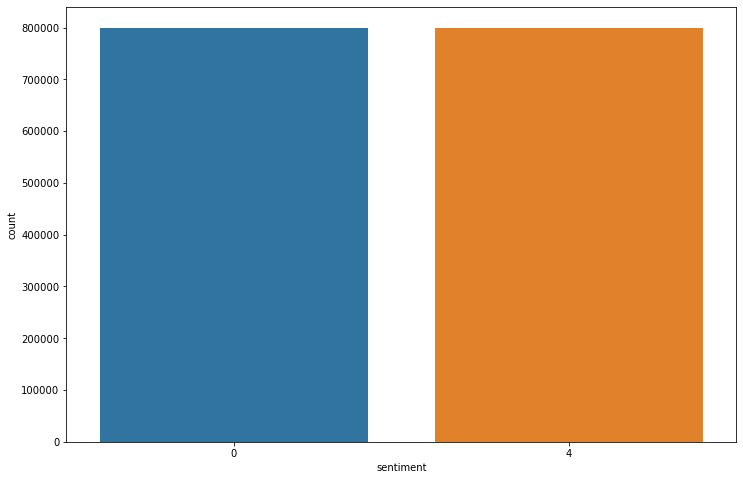

In [7]:
plt.subplots(figsize=(12, 8))
sns.countplot(data.sentiment)

#### Data cleaning

Droping some cols that will not be used

In [8]:
drop_cols = ['id', 'date', 'user', 'query']

data.drop(drop_cols, axis=1, inplace=True)

data.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


Defining X and y

In [9]:
X = data.iloc[:, 1].values
y = data.iloc[:, 0].values

X.shape, y.shape

((1600000,), (1600000,))

In [10]:
def clean_text(text:str):
    '''Cleaning a input text with nicks, links, tags, numbers and symbols'''
    text = BeautifulSoup(text, 'lxml').get_text()
    # remove user starting with @
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    #remove links
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    #remove numbers, allowing only this caracters below
    text = re.sub(r'[^A-Za-z]', ' ', text)
    #removing extras spaces
    text = re.sub(r' +', ' ', text)
    
    return text

Testing function...

In [11]:
test_text = '@lps08 this its a test! <hr> -= https://github.com/lps08'

clean_text(test_text)

' this its a test '

In [12]:
nlp = sp.load('en_core_web_sm')
stop_words = sp.lang.en.STOP_WORDS

def removing_stopwords(text:str):
    '''Removing stopwords from a input text'''
    text = text.lower()
    document = nlp(text)
    # get text words
    words = [word.text for word in document]
    # removing stopwords
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

Testing function...

In [13]:
removing_stopwords(clean_text(test_text))

'  test'

Aplying funtions to data and verifying if cleaning has been done

In [14]:
file_name = 'data-cleaned.npy'

try:
    # try to load data, if data cleaned was done before
    data_cleaned = np.load(file=file_name)

except:
    # if data cleaning was not done before
    data_cleaned = [removing_stopwords(clean_text(sentense)) for sentense in tqdm(X)]

    np.save(file_name, data_cleaned) 

# showing 4 exemplo of data cleanead
for _ in range(0, 4):
    print(data_cleaned[random.randint(0, len(data_cleaned))])

  know thatttt m naming child memory j t best degrassi lol
ate chicken today st time yrs stupid botswana having vegetarian foods forcing learn eat meat
woke weird dream boss damn ok think need write articles
  raining spare time


In [15]:
# changing label 4 to 1
y[y == 4] = 1

In [16]:
np.unique(y)

array([0, 1])

#### Tokenization

In [17]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(corpus_generator=data_cleaned, target_vocab_size=2**16)

In [18]:
print('vocab size: ', tokenizer.vocab_size)

vocab size:  65244


testing tokenizer

In [19]:
to = tokenizer.encode('Im so good')
to

[65061, 3, 14206, 107]

In [20]:
tokenizer.decode(to)

'Im so good'

In [21]:
data_input = [tokenizer.encode(setense) for setense in tqdm(data_cleaned)]

100%|██████████| 1600000/1600000 [00:21<00:00, 73588.34it/s]


In [22]:
# showing 4 exemplo of data input
for _ in range(0, 4):
    print(data_input[random.randint(0, len(data_input))])

[542, 18015, 72, 917]
[1850, 33, 188, 6, 543]
[1, 2, 6, 888]
[1, 909, 45325, 192, 336, 7974, 59951, 65020, 49989]


#### Padding

getting max vocab len in data input

In [23]:
max_len = max([len(setense) for setense in data_input])
print('max len: ', max_len)

max len:  47


applying padding

In [24]:
data_input = tf.keras.preprocessing.sequence.pad_sequences(data_input, value=0, padding='post', maxlen=max_len)

#### Train and test data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data_input, y, test_size=0.3, stratify=y)

In [26]:
X_train.shape, X_test.shape

((1120000, 47), (480000, 47))

In [27]:
y_train.shape, y_test.shape

((1120000,), (480000,))

### Model building

In [28]:
class DCNN(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim, num_filters, ffn_units, num_classes=2, dropout_rate=0.1, training=False, name='dcnn'):
        super(DCNN, self).__init__(name=name)

        self.num_classes = num_classes
        
        # embeding layer
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim)

        # convolutional layers
        # layer that analyse only two words back and forth
        self.bigram = self.__convolution_layer(kernel_size=2, num_filters=num_filters)
        # layer that analyse only three words back and forth
        self.trigram = self.__convolution_layer(kernel_size=3, num_filters=num_filters)
        # layer that analyse only three words back and forth
        self.fourgram = self.__convolution_layer(kernel_size=4, num_filters=num_filters)

        # pooling layer
        self.pool = layers.GlobalAveragePooling1D()

        # dense layer 1
        self.dense_1 = self.__dense_layer(units=ffn_units)
        # dropout rate
        self.dropout = self.__dropout_layer(dropout_rate=dropout_rate)

        # output layer
        self.output_layer = self.__output_layer(num_classes=num_classes)

    def call(self, inputs, training):
        emb = self.embedding(inputs)

        # first conv block
        conv1 = self.bigram(emb) # (batch_size, emb_dim, num_filters_conv1)
        conv1 = self.pool(conv1) # (batch_size, num_filters_conv1)

        # second conv block
        conv2 = self.trigram(emb) # (batch_size, emb_dim, num_filters_conv2)
        conv2 = self.pool(conv2) # (batch_size, num_filters_conv2)

        # third conv block
        conv3 = self.fourgram(emb) # (batch_size, emb_dim, num_filters_conv3)
        conv3 = self.pool(conv3) # (batch_size, num_filters_conv3)

        # concat 3 convolutional layers results
        merged = tf.concat([conv1, conv2, conv3], axis=-1) # (batch_size, 3 * num_filters)

        # pass concated convolutional results to dense layer
        merged = self.dense_1(merged)
        merged = self.dropout(merged)

        # return the results
        return self.output_layer(merged)

    def compile_model(self, optimizer='adam', metrics=['accuracy']):
        if self.num_classes == 2:
            return self.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
        return self.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=metrics)

    def __convolution_layer(self, kernel_size, num_filters):
        '''Return a convolutional layers given a kernel size and num filters'''
        return layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu')

    def __dense_layer(self, units):
        '''Return a dense layers given a num units'''
        return layers.Dense(units=units, activation='relu')

    def __dropout_layer(self, dropout_rate):
        '''Return a dense layers given a dropout rate'''
        return layers.Dropout(rate=dropout_rate)

    def __output_layer(self, num_classes):
        '''Return a dense layers given a num classes'''
        if num_classes == 2:
            return layers.Dense(units=1, activation='sigmoid')
        return layers.Dense(units=num_classes, activation='softmax')

#### hyperparans configuration

In [29]:
vocab_size = tokenizer.vocab_size
emb_dim = 200
num_filters = 100
ffn_units = 256
num_classes = len(np.unique(y))
dropout_rate = 0.2
epochs = 3
batch_size = 64

#### Training

In [30]:
dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, num_filters=num_filters, ffn_units=ffn_units, num_classes=num_classes, dropout_rate=0.2)

2022-03-25 11:18:32.756204: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-25 11:18:32.757274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-25 11:18:32.789429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 11:18:32.789544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.8095GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-03-25 11:18:32.789561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-25 11:18:32.790581: I tensorflow/stream_executor/platfo

In [31]:
dcnn.compile_model()

Checkpoint configuration

In [32]:
checkpoint_path = './'
ckpt = tf.train.Checkpoint(dcnn)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, directory=checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Checkpoint restored')

In [33]:
hist = dcnn.fit(x=X_train, y=y_train, batch_size=batch_size, verbose=1, validation_split=0.1, epochs=epochs)

ckpt_manager.save()

2022-03-25 11:18:33.312084: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 189504000 exceeds 10% of free system memory.
2022-03-25 11:18:33.457881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-25 11:18:33.458184: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3693240000 Hz
2022-03-25 11:18:33.542137: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52195200 exceeds 10% of free system memory.
2022-03-25 11:18:33.564462: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52195200 exceeds 10% of free system memory.
2022-03-25 11:18:33.575951: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52195200 exceeds 10% of free system memory.


Epoch 1/3


2022-03-25 11:18:33.669437: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 52195200 exceeds 10% of free system memory.
2022-03-25 11:18:33.934291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-25 11:18:34.036234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-25 11:18:34.486234: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-25 11:18:34.573107: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


15750/15750 [==============================] - 2449s 155ms/step - loss: 0.4898 - accuracy: 0.7588 - val_loss: 0.4450 - val_accuracy: 0.7890
Epoch 2/3
15750/15750 [==============================] - 2547s 162ms/step - loss: 0.4068 - accuracy: 0.8134 - val_loss: 0.4474 - val_accuracy: 0.7908
Epoch 3/3
15750/15750 [==============================] - 2794s 177ms/step - loss: 0.3503 - accuracy: 0.8437 - val_loss: 0.4706 - val_accuracy: 0.7821


'./ckpt-1'

The training took about 130 minutes

#### Evaluating model

In [34]:
res = dcnn.evaluate(x=X_test, y=y_test, batch_size=batch_size)
print('Result: ', res)

7500/7500 [==============================] - 12s 2ms/step - loss: 0.4706 - accuracy: 0.7830
Result:  [0.47062283754348755, 0.782952070236206]


In [35]:
pred = dcnn.predict(x=X_test)
pred = (pred > 0.5)

pred

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [37]:
confusion_res = confusion_matrix(y_true=y_test, y_pred=pred)
confusion_res

array([[192863,  47137],
       [ 57046, 182954]])

<AxesSubplot:>

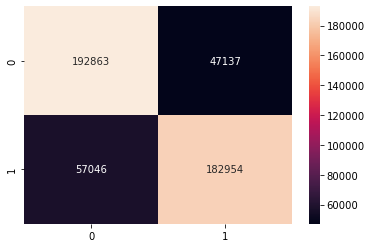

In [42]:
sns.heatmap(data=confusion_res, annot=True, fmt='d')

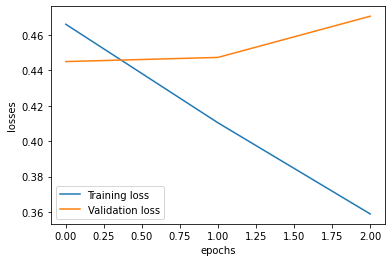

In [52]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(['Training loss', 'Validation loss'])

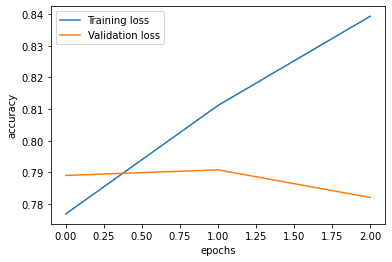

In [53]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training loss', 'Validation loss'])

prediction a input text

In [63]:
test = 'You are crazy'
test_tok = tokenizer.encode(test)

In [64]:
res_test = dcnn(np.array([test_tok]))
print('Result: ', res_test)

Result:  tf.Tensor([[0.00020485]], shape=(1, 1), dtype=float32)


In [65]:
print('Class: ', (res_test > 0.5))

Class:  tf.Tensor([[False]], shape=(1, 1), dtype=bool)
